In [60]:
########################### Libraries ####################################
import astropy
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from astropy.coordinates.angle_utilities import hms_to_degrees, dms_to_degrees
from astropy.coordinates import SkyCoord  # High-level coordinates
from astropy.coordinates import ICRS, Galactic, FK4, FK5  # Low-level frames
from astropy.coordinates import Angle, Latitude, Longitude  # Angles
import astropy.units as u
import re
import json
from collections import Counter
from operator import itemgetter
import scipy
from scipy.signal import argrelextrema
from astroML.time_series import lomb_scargle
from gatspy.periodic import LombScargleFast

In [61]:
#ОКПЗ
data = astropy.io.ascii.read('gcvs5.txt', data_start=2, delimiter='|')
data = data.to_pandas()
datalistt=data['Max'].tolist()
datalist=data['Min I'].tolist()

In [62]:
data.head()

,NNo,GCVS,J2000.0,Type,Max,Min I,Min II,Epoch,Year,Period,M-m,Spectrum,References,Other desig. p.m.(as/yr) Epoch Ident. New type GCVS
0,010001,R And *,002401.95 +383437.3,M,5.8,15.2,NaN,V |53820.,NaN,409.2,38,"S3,5e-S8,8e(M7e)",HIP 00002,|-0.016 -0.035|2000.0 | |Hip |M ...
1,010002,S And *,004243.1 +411605.0,SNI,5.8,< 16.,NaN,V |09775.,1885,NaN,NaN,(SNI),V 377 V 338,=M31 V0894| |1885.67 | |Lit. ...
2,010003,T And,002223.15 +265945.8,M,7.7,14.5,NaN,V |50854.,NaN,281.0,46,M4e-M7.5e,00001 00002,|-0.007 -0.003|2000.0 | |Tyc2 |M ...
3,010004,U And,011529.70 +404308.4,M,9.0,15.0,NaN,V |49564.,NaN,347.7,40,M6e,00001 00002,|+0.009 -0.011|2000.0 | |UCAC2 |M ...
4,010005,V And,005006.28 +353910.1,M,9.0,15.2,NaN,V |51528.,NaN,256.4,45,M2e-M3e,00001 00002,|-0.007 -0.007|2000.0 | |NPM |M ...


### GCVS input ('Max'  and 'Min I' columns) corrections

In [63]:
name=datalistt[39]# save strange nan?
for i in range(len(datalist)):
    try:
        if datalist[i][0]=='<':
            datalist[i]=datalist[i][2:]
        if datalist[i][-1]==':':
            datalist[i]=datalist[i][:4]
        if datalist[i][0]=='(':
            datalist[i]=100
    except:
        1==1
#         print(i)
        
for i in range(len(datalistt)):
    try:
        if datalistt[i]==datalistt[39]:
            datalistt[i]=0
        if datalistt[i][0]=='|':
            datalistt[i]=datalistt[1][1:]
    except:
        1==1
#         print(i)        

 # GCVS analyses  

### Here we remove stars which min mag< 12m

In [64]:
data['index']=data.index
i=0
k=0
index=[]
for i in range(len(datalist)):
    try:
        if float(datalist[i])<=10:
            index.append(i)
    except:
        print(1)
data=data.drop(index,axis=0)     
data=data.reset_index()        
data.shape

1
1


(48549, 16)

### Here we calculate the num of stars which max-min range does not fully belong to [12:20]

In [65]:
# k=0
# d=0
# for i in range(len(datalist)):
#     try:
#         if float(datalistt[i])<12:
#             d=d+1
# #             data=data.drop(index=i,axis=1)
#     except:
#         k=k+1
# print(d)
#18980

### result N of stars which belong to [12:20]

In [66]:
# data.shape[0]-d
#35999

In [67]:
# drop them
# data1=data1.drop(index=d,axis=1,inplace=True)
# data1=data1.reset_index()
# data1

### Take only necessary columns + coordinates preparation

In [68]:
# ОКПЗ
# data = astropy.io.ascii.read('gcvs5.txt', data_start=2, delimiter='|')

In [69]:
data = data[['J2000.0', 'Type']]

In [70]:
# data = data.to_pandas()

In [71]:
data.Type = data.Type.map(lambda item: re.sub(':', '', str(item) ) if str(item).endswith(':') else str(item) )

In [72]:
data.rename(columns={'J2000.0':'coord'}, inplace=True)

In [73]:
data.drop(index=data[data.coord.map(lambda x: type(x) is not str )].index.values.tolist(), inplace=True)

In [74]:
data = data[ data.coord.map(lambda x: len(str(x)) == 19 ) ]

In [75]:
data['ra'] = data.coord.map(lambda x: x[:9])
data['dec'] = data.coord.map(lambda x: x[9:])

In [76]:
data.dec = data.dec.map(lambda x: x.replace(' ', '') )

In [77]:
data = data[ (data.dec.map(lambda x: x.startswith('+')) | data.dec.map(lambda x: x.startswith('-')) )
            & data.dec.map(lambda x: len(x) == 9 ) ]

In [78]:
data.reset_index(drop=True, inplace=True)

In [79]:
data.ra = data.ra.map(lambda x: hms_to_degrees(float(x[:2]), float(x[2:4]), float(x[4:])) )
data.dec = data.dec.map(lambda x: dms_to_degrees(float(x[:3]), float(x[3:5]), float(x[5:])))

In [80]:
#sorted(Counter(data.Type).items(), key=itemgetter(1), reverse=True)

## Features engineering (for ML)

In [81]:
#Построение периодограммы (фурье спектра сигнала) для текущего значения obj_mag,obj_magerr,ang_freqs
# from astroML.time_series import lomb_scargle
# periods = np.linspace(0.01, 200, 500)
# ang_freqs = 2 * np.pi / periods
# power = lomb_scargle(np.array(obj_mjd), np.array(obj_mag), np.array(obj_magerr), ang_freqs)
# # plot the results
# fig, ax = plt.subplots()
# ax.plot(periods, power)
# ax.set(ylim=(0, 0.8), xlabel='period (days)',
#        ylabel='Lomb-Scargle Power');

In [82]:
# peak_data = scipy.signal.find_peaks(power,prominence=0.05)
# f1=np.max(power[peak_data[0]])
# ind1=power[peak_data[0]].argmax()
# power[peak_data[0][ind1]]=0
# f2=np.max(power[peak_data[0]])
# ind2=power[peak_data[0]].argmax()
# print(periods[peak_data[0][ind1]])
# print(periods[peak_data[0][ind2]])
# print(periods[ind1])
# print(periods[ind2])

In [83]:
# model = LombScargleFast().fit(np.array(obj_mjd), np.array(obj_mag), np.array(obj_magerr))
# period, power = model.periodogram_auto(nyquist_factor=200)
# print("period range: ({0}, {1})".format(period.min(), period.max()))
# print("number of periods: {0}".format(len(period)))
# print(type(periods))

In [84]:
data1=data# Для быстрой загрузки с сервера

In [85]:
# data1=data[42000:]

In [86]:
data1.iterrows()

<generator object DataFrame.iterrows at 0x0000024092913F48>

In [87]:
rows = np.random.choice(data.index.values, 3000)
print(data1.shape)
data1.head()

(48173, 4)


,coord,Type,ra,dec
0,002401.95 +383437.3,M,6.008125,38.577028
1,004243.1 +411605.0,SNI,10.679583,41.268056
2,002223.15 +265945.8,M,5.596458,26.996056
3,011529.70 +404308.4,M,18.873750,40.719000
4,005006.28 +353910.1,M,12.526167,35.652806


## Sending requests with different conditions and parameters + saving files

In [88]:
# %%time
# obj_mjd1={}
# obj_mag1={}
# periods = np.linspace(0.01, 200, 500)
# ang_freqs = 2 * np.pi / periods
# my_data = pd.DataFrame({'obj_id':[],
#                         'filter':[],
# #                         'mean_magn':[],
# #                         'amplitude':[],
# #                         'trand_angle':[],
# #                         'skew' : [],
# #                         'std' : [],
# #                         'max_PSD' : [],
# #                         'max_fs' : [],
#                         'pointsN': [],
#                         'idN': [],
#                         'dist':[],
# #                         'dist1':[],
# #                         'dist2':[],                        
#                         'class':[]})
# i=0
# for item in data1.iterrows():
# #     obj_mjd1[i]=obj_mjd
# #     obj_mag1[i]=obj_mag
# #     i=i+1
# #     a=item[1].ra*u.degree
# #     b=item[1].dec*u.degree
#     try:
#         resp = requests.get('http://db.ztf.snad.space/api/v1/circle/full/json?ra={ra}&dec={dec}&radius_arcsec={r}'.format(ra=item[1].ra, 
#                                                                                                                           dec=item[1].dec, 
#         res = resp.json()
#         i=i+1
#         if len(res.keys())==2:
                                                                                                                          
#             if i%1000==0:



#     #             if (res[obj_id]['meta']['filter']=='zg') & (len(res[obj_id]['lc'])>=5):
#                 obj_mjd = []
#                 obj_mag = []
#                 obj_magerr = []
#                 object_return = {}
#                 obj_filter = res[obj_id]['meta']['filter']
# #                     for ii in res[obj_id]['lc']:
# #                         obj_mjd.append(ii['mjd'])
# #                         obj_mag.append(ii['mag'])
# #                         obj_magerr.append(ii['magerr'])
#     #                 Fs = 1/((np.array(obj_mjd).max() - np.array(obj_mjd).min() )/np.array(obj_mjd).size)
#     #                 Fs = np.linspace(0.01, 10)
# #                     model = LombScargleFast().fit(obj_mjd, obj_mag, obj_magerr)
#     #                 period, power = model.periodogram_auto(nyquist_factor=200)
# #                     period=0
# #                     power=0


#                 object_return['obj_id'] = obj_id
#                 object_return['filter'] = res[obj_id]['meta']['filter']
# #                     object_return['mean_magn'] = np.array(obj_mag).mean()
# #                     object_return['amplitude'] = np.array(obj_mag).max() - np.array(obj_mag).min()
# #                     object_return['trand_angle'] = np.polyfit(np.array(obj_mjd), np.array(obj_mag), 1)[0] 
# #                     object_return['skew'] = scipy.stats.skew(np.array(obj_mag))
#                 object_return['pointsN'] = len(res[obj_id]['lc'])
#                 object_return['idN'] = len(res.keys())
# #                 object_return['dist'] = sep 
# #                 object_return['dist1'] = sep1
# #                 object_return['dist2'] = sep2

#     #                 D1=np.max(power[peak_data[0]])
#     #                 ind1=power[peak_data[0]].argmax()
#     #                 power[peak_data[0][ind1]]=0
#     #                 D2=np.max(power[peak_data[0]])
#     #                 ind2=power[peak_data[0]].argmax() 
# #                     object_return['max_fs'] =0
# #                     object_return['max_fs'] = 2*np.pi/(period[power.argmax()])
#     #                 object_return['max_fs1'] = 2*np.pi/(period[peak_data[0][ind2]])                
# #                     object_return['max_PSD'] = np.max(power)
#     #                 object_return['max_PSD1'] = D2
# #                     object_return['std'] = np.array(obj_mag).std()

#                 my_data = my_data.append( pd.DataFrame({'obj_id' : [ object_return['obj_id'] ],
#                                                           'filter' : [ object_return['filter'] ],
# #                                                           'mean_magn' :[ object_return['mean_magn'] ],
# #                                                           'amplitude' : [ object_return['amplitude'] ], 
# #                                                           'trand_angle' : [ object_return['trand_angle'] ],
# #                                                           'skew' : [ object_return['skew'] ],
# #                                                           'std' : [ object_return['std'] ],
# #                                                           'max_PSD' : [ object_return['max_PSD']],
# #                                                           'max_fs' : [ object_return['max_fs'] ],
#                                                           'pointsN' : [ object_return['pointsN']],
#                                                           'idN' : [ object_return['idN']],
#                                                           'dist' : [ object_return['dist']],
# #                                                           'dist1' : [ object_return['dist1']], 
# #                                                           'dist2' : [ object_return['dist2']],                                                           
#                                                           'class' : [ item[1].Type ] }),
#                                              ignore_index = True)
    
#     except Exception as ex:
#         print("file {} has error".format(item[0]), ex)
#     if item[0] % 1000 == 0 :
#         my_data.to_csv('backup_' + str(item[0]) + '.csv')    

### Viewing all the names in folder

In [115]:
from os import walk
f = []
mypath=r'C:\Users\rtut6\Desktop\Backup\4' # first (1) or second (2) folder
for (dirpath, dirnames, filenames) in walk(mypath):
    f.extend(filenames)
    break

In [116]:
f

['10016.txt',
 '10019.txt',
 '10026.txt',
 '10041.txt',
 '10050.txt',
 '10054.txt',
 '10060.txt',
 '10085.txt',
 '10092.txt',
 '10095.txt',
 '10125.txt',
 '10129.txt',
 '10132.txt',
 '10151.txt',
 '10152.txt',
 '10171.txt',
 '10173.txt',
 '10176.txt',
 '10184.txt',
 '102.txt',
 '10250.txt',
 '10254.txt',
 '10256.txt',
 '1083.txt',
 '1090.txt',
 '1100.txt',
 '1104.txt',
 '11078.txt',
 '11090.txt',
 '11094.txt',
 '11101.txt',
 '11102.txt',
 '11111.txt',
 '11162.txt',
 '11194.txt',
 '11417.txt',
 '11482.txt',
 '11521.txt',
 '11586.txt',
 '11589.txt',
 '11590.txt',
 '11593.txt',
 '11594.txt',
 '11596.txt',
 '11597.txt',
 '11658.txt',
 '11709.txt',
 '11727.txt',
 '11744.txt',
 '11752.txt',
 '11786.txt',
 '11790.txt',
 '1188.txt',
 '1189.txt',
 '11896.txt',
 '11943.txt',
 '11955.txt',
 '11976.txt',
 '12011.txt',
 '12074.txt',
 '12097.txt',
 '12102.txt',
 '12103.txt',
 '12104.txt',
 '12105.txt',
 '12110.txt',
 '12116.txt',
 '12117.txt',
 '12156.txt',
 '12160.txt',
 '12163.txt',
 '12167.txt',


In [117]:
for i in range(len(f)):
    try:
        f[i]=f[i][:-4]
    except:
        print('1')

In [92]:
for i in range(len(f)):
    if len(f[i])<13:
        f.pop(i) 
names1=f

IndexError: list index out of range

### Fill names1 with files of first folder (1 id ) and names 2 with files of second folder (2 id) etc.

In [118]:
names4=f
# names2=f
# names3=f
# import plotly.express as px

### id-distribution (numbers come from number of elements in folders

In [ ]:
# # my_data.head(20)
# import chart_studio.plotly as py
# import plotly.graph_objs as go

# values = '2.0 ID', '4.0 ID', '1.0 ID', '3.0 ID','6.0 ID'
# sizes = [12580, 1610, 5330, 273,48] # Размеры пяти самых больших классов

# trace = go.Pie(labels=labels, values=values)

# py.iplot([trace], filename='basic_pie_chart')


### Distribution for distances in GCVS-ZTF for answers with 1 ID, r=5arcsec

In [ ]:
df = pd.read_csv(r'1IDobj.csv',sep='\t')
df['dist1']=df['dist1']
df['dist1'].hist(bins=100)
plt.title ("Distribution for distances in GCVS-ZTF for answers with 1 ID, r=5arcsec") #данные по всему каталогу 

In [ ]:
# listl=[]
# for item in names2: 
#     with open(r"C:\Users\rtut6\Desktop\Backup\2\{}.txt".format(item)) as file:
#         res = file.read().replace("'", '"')
#     res=json.loads(res)
#     c1=SkyCoord(res[list(res.keys())[0]]['meta']['coord']['ra']*u.degree, res[list(res.keys())[0]]['meta']['coord']['dec']*u.degree)
#     c2=SkyCoord(res[list(res.keys())[1]]['meta']['coord']['ra']*u.degree, res[list(res.keys())[1]]['meta']['coord']['dec']*u.degree)
#     sep0 = c1.separation(c2)
#     listl.append(sep0.value)

In [ ]:
# with open('listl.csv', 'wb') as f:
#     pickle.dump(listl, f)

In [ ]:
import pickle
with open('listl.csv', 'rb') as f:
    listl = pickle.load(f)

In [ ]:
# for i in range(len(listl)):
#     listl[i]=listl[i]*3600

### Distribution for distances in ZTF for answers with 2 id (between ids), r=1.5arcsec

In [ ]:
df=pd.DataFrame(index=range(len(listl)),columns=['degr'])
df['degr']=listl
df.hist(bins=100)
# np.cumsum(a)
plt.title ("Distribution for distances in ZTF for answers with 2 id (between ids), r=1.5arcsec") #данные по всему каталогу 

### Create a DataFrame:

In [213]:
# df=pd.DataFrame(columns=['ra','dec','Nobs','filter','Name'],index=range(35000))

### Each new row - one single observation (for each 2-id object we get 2 rows)

In [218]:
# i=0
n=1
listm=[0,0]
types=['zg','zr']
for item in names1: # names1 or names2 (replace to switch)
    with open(r"C:\Users\rtut6\Desktop\Backup\1\{}.txt".format(item)) as file: # 2 or 1 folder (replace to switch)
        res = file.read().replace("'", '"')
    res=json.loads(res)
    
#     temp=0
    
    if res[list(res.keys())[0]]['meta']['nobs']>res[list(res.keys())[1]]['meta']['nobs']:
        m=1
    else:
        m=0
#         if res[list(res.keys())[j]]['meta']['filter']==typ[0]:
#             if res[list(res.keys())[j]]['meta']['nobs']>temp:
#                 temp=res[list(res.keys())[j]]['meta']['nobs']
#                 listm[0]=j
#     temp=0            
#     for j in range(n):
#         if res[list(res.keys())[j]]['meta']['filter']==typ[1]:
#             if res[list(res.keys())[j]]['meta']['nobs']>temp:
#                 temp=res[list(res.keys())[j]]['meta']['nobs']
#                 listm[1]=j                

    df['ra'][i]=round(res[list(res.keys())[m]]['meta']['coord']['ra'],3)
    df['dec'][i]=res[list(res.keys())[m]]['meta']['coord']['dec']
    df['Nobs'][i]=res[list(res.keys())[m]]['meta']['nobs']
    df['filter'][i]=res[list(res.keys())[m]]['meta']['filter']
    df['Name'][i]=item
    i=i+1

    
#         if res[list(res.keys())[j]]['meta']['filter']=='zr':
#             df['ra'][i]=round(res[list(res.keys())[j]]['meta']['coord']['ra'],3)
#             df['dec'][i]=res[list(res.keys())[j]]['meta']['coord']['dec']
#             df['Nobs'][i]=res[list(res.keys())[j]]['meta']['nobs']
#             df['filter'][i]='zr'
#             df['Name'][i]=item
#             i=i+1 
    
            
#     df.append([res[list(res.keys())[1]]['meta']['coord']['ra']],[res[list(res.keys())[1]]['meta']['coord']['dec']])
#     if sep0.value*3600>0.5 or res[list(res.keys())[0]]['meta']['fieldid']==res[list(res.keys())[1]]['meta']['fieldid'] and res[list(res.keys())[0]]['meta']['filter']==res[list(res.keys())[1]]['meta']['filter']:
#     special1.append(item)
# special1        
#     sep1 = c2.separation(c0)
#     df['dist1'][i]=sep0.value
#     df['dist2'][i]=sep1.value
#     if len(d2.keys())==3:
#         list3[k]=item
#         k=k+1
#     d=d+1    
#     if d % 1000==0:
#             print(d)

In [219]:
i

14198

In [119]:
names2

['10',
 '100',
 '10000',
 '10001',
 '10002',
 '10004',
 '10005',
 '10006',
 '10008',
 '10009',
 '10010',
 '10012',
 '10013',
 '10014',
 '10015',
 '10017',
 '10020',
 '10021',
 '10022',
 '10023',
 '10025',
 '10027',
 '10030',
 '10031',
 '10032',
 '10033',
 '10034',
 '10035',
 '10036',
 '10037',
 '10038',
 '10039',
 '10040',
 '10042',
 '10044',
 '10045',
 '10046',
 '10047',
 '10048',
 '10051',
 '10052',
 '10053',
 '10056',
 '10057',
 '10058',
 '10059',
 '10062',
 '10063',
 '10064',
 '10065',
 '10066',
 '10069',
 '10070',
 '10071',
 '10072',
 '10073',
 '10074',
 '10075',
 '10076',
 '10077',
 '10078',
 '10079',
 '10081',
 '10082',
 '10083',
 '10086',
 '10088',
 '10089',
 '10090',
 '10093',
 '10094',
 '10096',
 '10098',
 '10099',
 '10101',
 '10103',
 '10104',
 '10105',
 '10107',
 '10108',
 '10109',
 '10110',
 '10113',
 '10114',
 '10115',
 '10116',
 '10117',
 '10118',
 '10119',
 '10120',
 '10121',
 '10122',
 '10127',
 '10128',
 '10130',
 '10133',
 '10134',
 '10137',
 '10138',
 '10141',
 '101

In [140]:
data1

,coord,Type,ra,dec
0,002401.95 +383437.3,M,6.008125,38.577028
1,004243.1 +411605.0,SNI,10.679583,41.268056
2,002223.15 +265945.8,M,5.596458,26.996056
3,011529.70 +404308.4,M,18.873750,40.719000
4,005006.28 +353910.1,M,12.526167,35.652806
...,...,...,...,...
48168,194926.98 +213443.6,SRA,297.362417,21.578778
48169,195052.40 +200453.0,SRA,297.718333,20.081389
48170,195208.25 +274220.9,NA,298.034375,27.705806
48171,195921.34 +263847.6,EB,299.838917,26.646556


### Next we want to match coordinates of an object with its type of variability

### Here some problems with merging initial dataframe (data1) with new one (df)

In [ ]:
# df[df['ra']==290.22]

In [ ]:
# data1[data1['ra']==290.22]

### With "merge" function we'll have all possible combinations of ra from data1 and df (if they are the same). Here -18 rows. Because of that we have to filter rows of our dataframe by dec in data1 and df

In [141]:
for i in range(data1.shape[0]):
    data1['ra'][i]=round(data1['ra'][i],3)

C:\Users\rtut6\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [220]:
# dff=pd.merge(df, data1, on='ra')
df1=df.merge(data1, left_on=['ra'], right_on=['ra'])

In [221]:
# Error correction
index=[]
for i in range(df1.shape[0]):
    if abs(df1['dec_x'][i]-df1['dec_y'][i])>=0.002:
        index.append(i)
df1=df1.drop(index,axis=0)  

In [222]:
df1 = df1.reset_index(drop=True)

In [224]:
df1.to_csv('df1_homogen_summ.csv')

In [223]:
df1

,ra,dec_x,Nobs,filter,Name,coord,Type,dec_y
0,183.954,18.5393,33,zg,10016,121549.00 +183221.4,RR,18.539278
1,192.503,31.14,38,zg,10019,125000.62 +310824.0,RRAB,31.140000
2,199.532,28.8968,38,zg,10026,131807.71 +285348.6,RRAB,28.896833
3,184.695,23.6454,33,zg,10041,121846.69 +233843.1,M,23.645306
4,188.368,22.4778,35,zg,10050,123328.24 +222839.6,RRAB,22.477667
...,...,...,...,...,...,...,...,...
12994,36.116,-10.6764,33,zg,9647,022427.86 -104034.9,EA,-10.676361
12995,38.664,4.92455,29,zg,9648,023439.44 +045528.5,RRC,4.924583
12996,34.218,48.901,45,zg,97,021652.24 +485403.7,SR,48.901028
12997,79.211,-27.4735,10,zg,9962,051650.62 -272824.5,RRAB,-27.473472


In [ ]:
# df1.to_csv('df123.csv', sep='\t')

### V types from GCVS:

In [232]:
eruptive=['FU', 'GCAS', 'I', 'IA', 'IB', 'IN', 'INA', 'INB', 'INT', 'IT', 'IN(YY)', 'IS', 'ISA',
          'ISB', 'RCB', 'RS', 'SDOR', 'UV', 'UVN', 'WR']
pulsating=['ACYG', 'BCEP', 'BCEPS', 'CEP', 'CEP(B)', 'CW', 'CWA', 'CWB', 'DCEP', 'DCEPS',
           'DSCT', 'DSCTC', 'GDOR', 'L', 'LB', 'LC', 'M', 'PVTEL', 'RPHS', 'RR', 'RR(B)', 'RRAB',
           'RRC', 'RV', 'RVA', 'RVB', 'SR', 'SRA', 'SRB', 'SRC', 'SRD', 'SXPHE', 'ZZ', 'ZZA', 'ZZB']
rotating=['ACV', 'ACVO', 'BY', 'ELL', 'FKCOM', 'PSR', 'SXARI']
cataclysmic=['N', 'NA', 'NB', 'NC', 'NL', 'NR','SN', 'SNI', 'SNII', 'UG', 'UGSS', 'UGSU', 'UGZ', 'ZAND']
eclipsing=['E', 'EA', 'EB', 'EW', 'GS', 'PN', 'RS', 'WD', 'WR', 'AR', 'D', 'DM','DS', 'DW', 'K', 'KE', 'KW', 'SD']
intense=['X', 'XB', 'XF', 'XI', 'XJ', 'XND', 'XNG', 'XP', 'XPR','XPRM', 'XM']
other=['BLLAC', 'CST', 'GAL', 'L:', 'QSO', 'S', '*', '+', ':','ZZO', 'AM', 'R', 'BE', 'LBV', 'BLBOO', 'EP', 'SRS', 'LPB']

### Make a new column ('Num') with class of variability

In [233]:
# #Numerate classes
df1['Num']=0
for i in range(df1.shape[0]):
    if df1['Type'][i] in eruptive:
        df1['Num'][i]=0
        continue
    if df1['Type'][i] in pulsating:
        df1['Num'][i]=1
        continue
    if df1['Type'][i] in rotating:
        df1['Num'][i]=2
        continue
    if df1['Type'][i] in cataclysmic:
        df1['Num'][i]=3
        continue
    if df1['Type'][i] in eclipsing:
        df1['Num'][i]=4
        continue
    if df1['Type'][i] in intense:
        df1['Num'][i]=5
    else:
        df1['Num'][i]=6

C:\Users\rtut6\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\rtut6\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\rtut6\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\rtut6\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value

### Look at names of files in pulsating type:

In [ ]:
# df1[df1['Num']==1]['Name'].tolist()

In [ ]:
df12=pd.read_csv('df1.csv', sep='\t')

In [ ]:
frames = [df1, df12]
df2=pd.concat(frames)

In [ ]:
df1=df2

### Calculate the numb of objects with Nobs> ... for each class

In [225]:
Nobs=pd.DataFrame(columns=['Type','N30','N50','N70'])

In [226]:
names=df1['Type'].value_counts()[:50].index.tolist()

In [227]:
Nobs=Nobs.drop('Type',axis=1)

In [228]:
indexk=[]
indexl=[]
indexm=[]
for item in names:
    k=0
    l=0
    m=0
    Frame=df1[df1['Type']==item]
    for i in range(len(Frame['Nobs'])):
        if Frame['Nobs'].tolist()[i]>30:
            k=k+1
        if Frame['Nobs'].tolist()[i]>50:
            l=l+1
        if Frame['Nobs'].tolist()[i]>70:
            m=m+1    
    indexk.append(k)
    indexl.append(l)
    indexm.append(m)
#     print(item,'k=',k)    
Nobs['N30']=indexk
Nobs['N50']=indexl
Nobs['N70']=indexm

In [378]:
df1=pd.read_csv('df1_homogen_zg.csv')
df2=pd.read_csv('df1_homogen_zr.csv')
df3=pd.read_csv('df1_homogen_summ.csv')

In [370]:
FrameX=pd.DataFrame(columns=['index','values'])
FrameX['index']=df1['Nobs'].value_counts()[:100].index
FrameX['values']=df1['Nobs'].value_counts()[:100].values
FrameX=FrameX.sort_values('index')
FrameX=FrameX.reset_index()   
FrameX=FrameX.drop('level_0',axis=1)

In [371]:
FrameX

,index,values
0,12,61
1,13,49
2,14,52
3,15,126
4,16,115
...,...,...
95,148,95
96,149,59
97,150,49
98,152,44


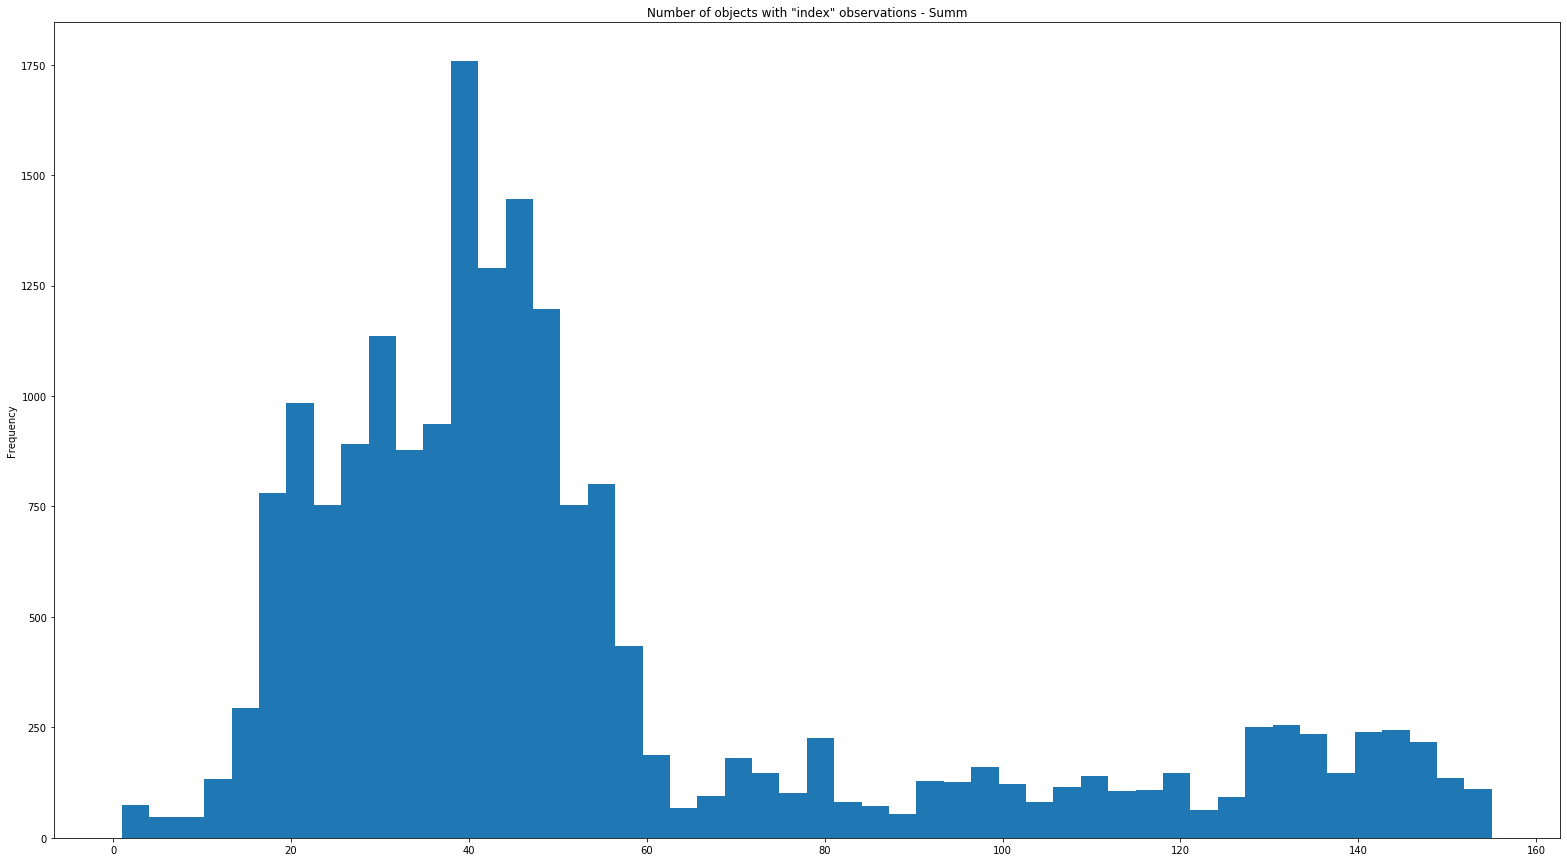

In [372]:
df1['Nobs'].plot(x='Nobs',kind='hist',figsize=(27,15),title='Number of objects with "index" observations - Summ',bins=50)

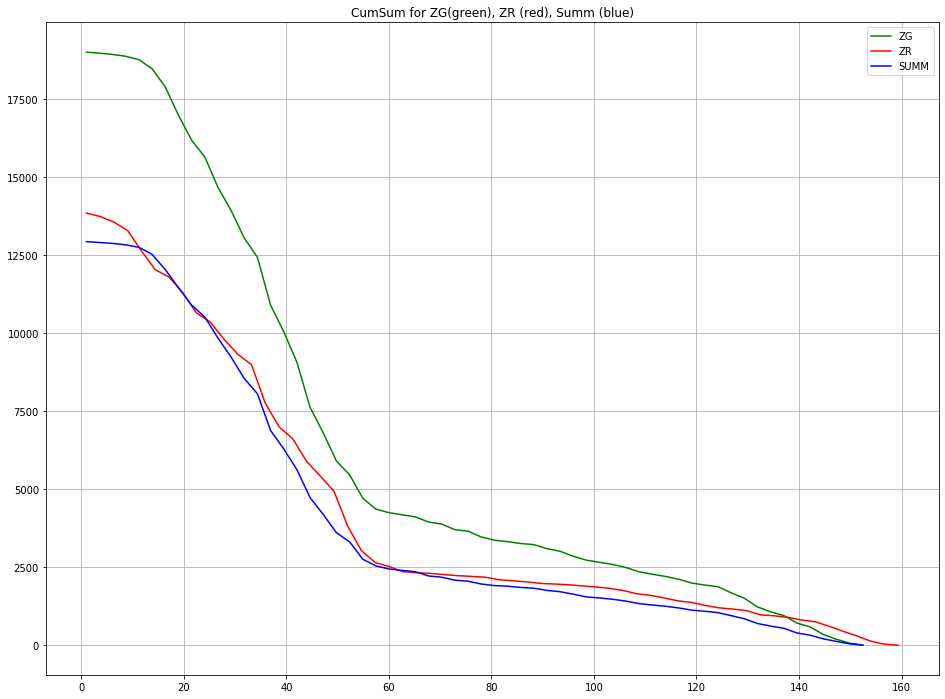

In [393]:
# some fake data
data1 = df1['Nobs'].tolist()
data2 = df2['Nobs'].tolist()
data3 = df3['Nobs'].tolist()
# evaluate the histogram
values1, base1 = np.histogram(data1, bins=60)
values2, base2 = np.histogram(data2, bins=60)
values3, base3 = np.histogram(data3, bins=60)
#evaluate the cumulative
cumulative1 = np.cumsum(values1)
cumulative2 = np.cumsum(values2)
cumulative3 = np.cumsum(values3)

# plot the cumulative function
# plt.plot(cumulative,base[:-1], c='blue')
#plot the survival function
plt.plot(base1[:-1], len(data1)-cumulative1, c='green')
plt.plot(base2[:-1], len(data2)-cumulative2, c='red')
plt.plot(base3[:-1], len(data3)-cumulative3, c='blue',)
plt.legend(['ZG','ZR','SUMM'])

plt.grid(True)
plt.title('CumSum for ZG(green), ZR (red), Summ (blue)')
plt.show()

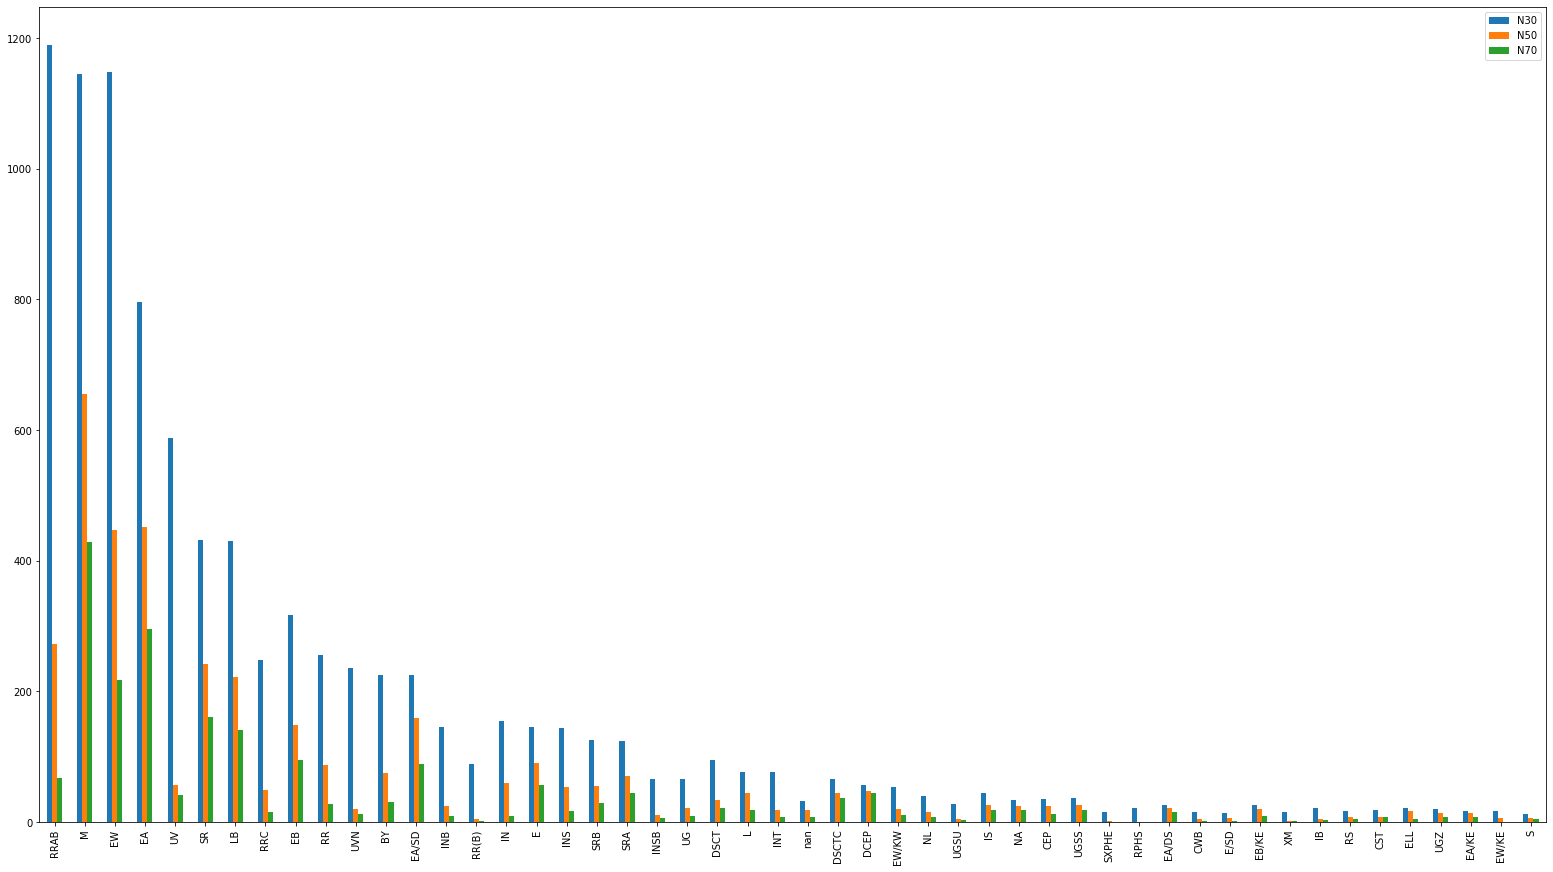

In [230]:
# dfff0=pd.DataFrame(list(zip(names,Nobs[Nobs['filter']=='zg']['Type'].value_counts().tolist(),df1[df1['filter']=='zr']['Type'].value_counts().tolist())),columns=['name','zg','zr'])
# dfff=df1['Type'].value_counts()[:100]
# dfff0.index=names
Nobs.plot(kind='bar',figsize=(27,15))

In [ ]:
Nobs[Nobs['Type']=='CEP']['N50'].tolist()[0]+Nobs[Nobs['Type']=='BCEP']['N50'].tolist()[0]+Nobs[Nobs['Type']=='DCEP']['N50'].tolist()[0]


In [249]:
df1

,ra,dec_x,Nobs,filter,Name,coord,Type,dec_y,Num
0,183.954,18.5393,33,zg,10016,121549.00 +183221.4,RR,18.539278,1
1,192.503,31.14,38,zg,10019,125000.62 +310824.0,RRAB,31.140000,1
2,199.532,28.8968,38,zg,10026,131807.71 +285348.6,RRAB,28.896833,1
3,184.695,23.6454,33,zg,10041,121846.69 +233843.1,M,23.645306,1
4,188.368,22.4778,35,zg,10050,123328.24 +222839.6,RRAB,22.477667,1
...,...,...,...,...,...,...,...,...,...
12994,36.116,-10.6764,33,zg,9647,022427.86 -104034.9,EA,-10.676361,4
12995,38.664,4.92455,29,zg,9648,023439.44 +045528.5,RRC,4.924583,1
12996,34.218,48.901,45,zg,97,021652.24 +485403.7,SR,48.901028,1
12997,79.211,-27.4735,10,zg,9962,051650.62 -272824.5,RRAB,-27.473472,1


In [ ]:
names=df1['Type'].value_counts()[:100].index.tolist()

In [ ]:
dfff0=pd.DataFrame(list(zip(names,df1[df1['filter']=='zg']['Type'].value_counts().tolist(),df1[df1['filter']=='zr']['Type'].value_counts().tolist())),columns=['name','zg','zr'])
# dfff=df1['Type'].value_counts()[:100]
dfff0.index=names
dfff0.plot(kind='bar',figsize=(20,10))

In [ ]:
k=0
list1=[]
df11=df1[df1['filter']=='zr']
for item in names:
    list1.append(df11[df11['Type']==item]['Nobs'].sum()/df11[df11['Type']==item].shape[0])
    k=k+1
t=0
list2=[]
df11=df1[df1['filter']=='zg']
for item in names:
    list2.append(df11[df11['Type']==item]['Nobs'].sum()/df11[df11['Type']==item].shape[0])
    t=t+1    

In [ ]:
obs=pd.DataFrame(list(zip(names,list1, list2)),columns=['Type','zg','zr'])
obs['Type']=names

for i in range(obs.shape[0]):
    obs['zg'][i]=int(obs['zg'][i])
    obs['zr'][i]=int(obs['zr'][i])
obs.index=obs['Type']    

In [ ]:
obs.plot(kind='bar',figsize=(20,10))

In [ ]:
df1

In [248]:
names

['42755', '12512', '20581', '6970', '4634']

### Plot  curves for five random objects of type 'n'

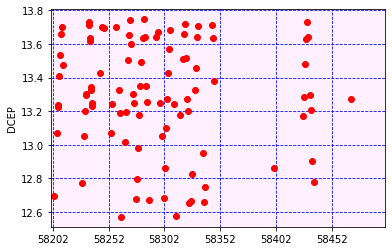

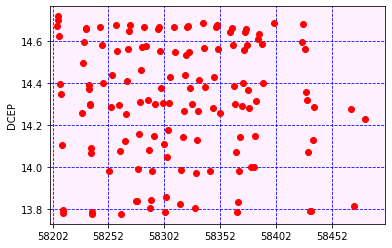

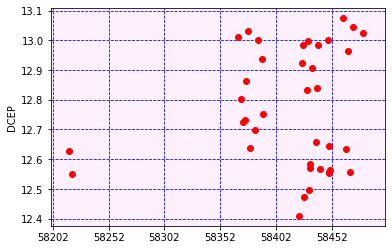

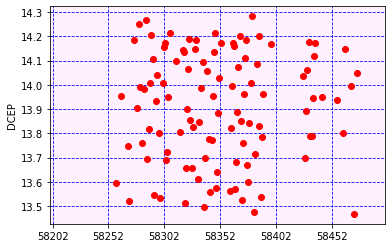

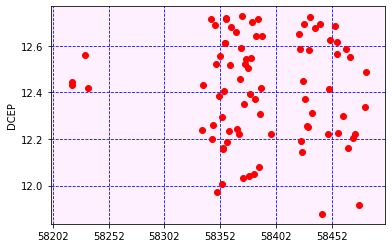

In [247]:
import random
from os import path
import matplotlib.backends.backend_pdf
import matplotlib.dates as mdates
outpath = "path/of/your/folder/"
# n=1
pdf = matplotlib.backends.backend_pdf.PdfPages(str(n)+".pdf")
names=random.sample(df1[df1['Type']=='DCEP']['Name'].tolist(), 5)
for item in names:
    with open(r"C:\Users\rtut6\Desktop\Backup\2\{}.txt".format(item)) as file:
        res = file.read().replace("'", '"')
        res=json.loads(res)
    x=[]
    y=[]
    for i in range(len(res[list(res.keys())[1]]['lc'])):
        x.append(res[list(res.keys())[1]]['lc'][i]['mjd'])
        y.append(res[list(res.keys())[1]]['lc'][i]['mag'])


        
        
#         days = mdates.drange(start,end,dt.timedelta(days=1))

    f=plt.figure()
    plt.gca().set_xlim([58200,58500])
#     axes.set_ylim([ymin,ymax])
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=50))
    ax = plt.gca()
    ax.set_facecolor((1.0, 0.94, 1))
    plt.plot(x,y,'ro')
    
#     plt.gcf().autofmt_xdate()
    plt.ylabel(df1[df1['Name']==item]['Type'].tolist()[0])
    plt.grid(True,color='blue',linestyle="--")
    pdf.savefig(f) #saving pdf
    plt.show()
pdf.close()

In [236]:
# my_data = pd.DataFrame({'obj_id':[],
#                         'filter':[],
#                         'mean_magn':[],
#                         'amplitude':[],
#                         'trand_angle':[],
#                         'skew' : [],
#                         'std' : [],
#                         'max_PSD' : [],
#                         'max_fs' : [],
#                         'pointsN': [],
#                         'idN': [],
#                         'dist':[],
#                         'dist1':[],
#                         'dist2':[],                        
#                         'class':[]})

In [ ]:
# %%time
# obj_mjd1={}
# obj_mag1={}
# periods = np.linspace(0.01, 200, 500)
# ang_freqs = 2 * np.pi / periods





#                 if (res[obj_id]['meta']['filter']=='zg') & (len(res[obj_id]['lc'])>=5):
#                 obj_mjd = []
#                 obj_mag = []
#                 obj_magerr = []
#                 object_return = {}
#                 obj_filter = res[obj_id]['meta']['filter']
#                     for ii in res[obj_id]['lc']:
#                         obj_mjd.append(ii['mjd'])
#                         obj_mag.append(ii['mag'])
#                         obj_magerr.append(ii['magerr'])
#                     Fs = 1/((np.array(obj_mjd).max() - np.array(obj_mjd).min() )/np.array(obj_mjd).size)
#                     Fs = np.linspace(0.01, 10)
#                     model = LombScargleFast().fit(obj_mjd, obj_mag, obj_magerr)
#                     period, power = model.periodogram_auto(nyquist_factor=200)
#                     period=0
#                     power=0


#                 object_return['obj_id'] = obj_id
#                 object_return['filter'] = res[obj_id]['meta']['filter']
#                     object_return['mean_magn'] = np.array(obj_mag).mean()
#                     object_return['amplitude'] = np.array(obj_mag).max() - np.array(obj_mag).min()
#                     object_return['trand_angle'] = np.polyfit(np.array(obj_mjd), np.array(obj_mag), 1)[0] 
#                     object_return['skew'] = scipy.stats.skew(np.array(obj_mag))
#                 object_return['pointsN'] = len(res[obj_id]['lc'])
#                 object_return['idN'] = len(res.keys())
#                 object_return['dist'] = sep 
#                 object_return['dist1'] = sep1
#                 object_return['dist2'] = sep2

#                     D1=np.max(power[peak_data[0]])
#                     ind1=power[peak_data[0]].argmax()
#                     power[peak_data[0][ind1]]=0
#                     D2=np.max(power[peak_data[0]])
#                     ind2=power[peak_data[0]].argmax() 
#                     object_return['max_fs'] =0
#                     object_return['max_fs'] = 2*np.pi/(period[power.argmax()])
#                     object_return['max_fs1'] = 2*np.pi/(period[peak_data[0][ind2]])                
#                     object_return['max_PSD'] = np.max(power)
#                     object_return['max_PSD1'] = D2
#                     object_return['std'] = np.array(obj_mag).std()

#                 my_data = my_data.append( pd.DataFrame({'obj_id' : [ object_return['obj_id'] ],
#                                                           'filter' : [ object_return['filter'] ],
#                                                           'mean_magn' :[ object_return['mean_magn'] ],
#                                                           'amplitude' : [ object_return['amplitude'] ], 
#                                                           'trand_angle' : [ object_return['trand_angle'] ],
#                                                           'skew' : [ object_return['skew'] ],
#                                                           'std' : [ object_return['std'] ],
#                                                           'max_PSD' : [ object_return['max_PSD']],
#                                                           'max_fs' : [ object_return['max_fs'] ],
#                                                           'pointsN' : [ object_return['pointsN']],
#                                                           'idN' : [ object_return['idN']],
#                                                           'dist' : [ object_return['dist']],
#                                                           'dist1' : [ object_return['dist1']], 
#                                                           'dist2' : [ object_return['dist2']],                                                           
#                                                           'class' : [ item[1].Type ] }),
#                                              ignore_index = True)
    
#     except Exception as ex:
#         print("file {} has error".format(item[0]), ex)
#     if item[0] % 1000 == 0 :
#         my_data.to_csv('backup_' + str(item[0]) + '.csv')    

In [ ]:
with open(r"C:\Users\rtut6\Desktop\Backup\2\20048.txt".format(item)) as file: 
    res = file.read().replace("'", '"')
    res=json.loads(res)

In [ ]:
x=[]
y=[]
for i in range(len(res[list(res.keys())[1]]['lc'])):
    x.append(res[list(res.keys())[1]]['lc'][i]['mjd'])
    y.append(res[list(res.keys())[1]]['lc'][i]['mag'])

In [ ]:
plt.plot(x, y, 'ro')
plt.show()

In [ ]:
names

# Machine Learning 

In [ ]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import train_test_split
# from xgboost import XGBClassifier
# from sklearn.metrics import average_precision_score
# from sklearn.metrics import mean_absolute_error
# from sklearn.metrics import roc_curve, auc,recall_score,precision_score
# from sklearn.metrics import accuracy_score

In [ ]:
# data1=df.drop(['filter','obj_id'], axis=1)

In [ ]:
# RandomForestClassifier

In [ ]:
# df1=df.iloc[1500:1725]
# array = data1.values
# X = array[:,0:7]
# Y = array[:,7]
# validation_size = 0.2
# seed = 5
# X_train=X[0:1500]
# X_validation=X[1500:1725]
# Y_train=Y[0:1500]
# Y_validation=Y[1500:1725]
# X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=seed)
# X_train1, X_testt, Y_train1, Y_testt = train_test_split(X_train, Y_train, test_size=validation_size1, random_state=seed)
# print(Y)
# train.head()

In [ ]:
#Learning with XGB model
# model = XGBClassifier(random_state=34, seed=7, colsample_bytree=0.8, subsample=0.6, n_estimators=2000)
# model.fit(X_train,Y_train)
# pred = model.predict(X_validation)
# accuracy = accuracy_score(Y_validation, pred)
# print("Accuracy: %.2f%%" % (accuracy * 100.0))

In [ ]:
# df1['pred']=pred
# df1.head(1000)

In [ ]:
# plt.figure(figsize=(10,5))
# plt.plot(np.array(obj_mjd1[9]), np.array(obj_mag1[9]))

In [ ]:
# obj_mag